progress: -0.00025910139083862305, direction_reward: -0.9368067979812622
Episode: 0, Step: 1000, Counter: 0, Total reward: -910.6808471679688, final state: tensor([ 0.3959, -0.2218, -0.3000,  0.3000])
progress: -0.00022047758102416992, direction_reward: -0.861957311630249
progress: -0.0002956688404083252, direction_reward: -0.45406126976013184
progress: -6.577372550964355e-05, direction_reward: -0.21996566653251648
progress: 0.000614464282989502, direction_reward: 0.9910410642623901
progress: 0.0008548498153686523, direction_reward: 0.9265815019607544
progress: 0.00034362077713012695, direction_reward: 0.6858758330345154
progress: 0.00031381845474243164, direction_reward: 0.9953795075416565
progress: 0.0004121065139770508, direction_reward: 0.9942017793655396
progress: 7.849931716918945e-05, direction_reward: 0.32678788900375366
progress: 0.0002891421318054199, direction_reward: 0.6860144734382629
progress: -0.00030601024627685547, direction_reward: -0.6877540349960327
progress: 0.0007

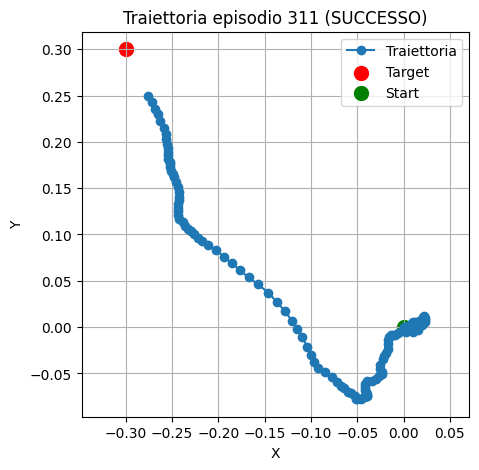

progress: -9.635090827941895e-05, direction_reward: -0.11735272407531738
progress: 0.0028595030307769775, direction_reward: 0.9846455454826355
progress: -1.4036893844604492e-05, direction_reward: 0.059220075607299805
progress: -0.0013232529163360596, direction_reward: -0.5933474898338318
progress: 0.0016084611415863037, direction_reward: 0.679927408695221
progress: 0.0010038018226623535, direction_reward: 0.42530521750450134
progress: -0.0002714097499847412, direction_reward: -0.10155799984931946
progress: -0.0010343194007873535, direction_reward: -0.7000873684883118
Episode: 319, Step: 157, Counter: 11, Total reward: 644.574951171875, final state: tensor([-0.2616,  0.2827, -0.3000,  0.3000])
progress: -0.0015547871589660645, direction_reward: -0.9994652271270752
progress: -8.046627044677734e-06, direction_reward: -0.006282240152359009
Episode: 321, Step: 134, Counter: 12, Total reward: 584.454833984375, final state: tensor([-0.2778,  0.2576, -0.3000,  0.3000])
progress: 0.000689417123

KeyboardInterrupt: 

In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from environment import TrackingEnv

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

MAX_EPISODES = 10000
NUM_NEURONS = 128
LR_CRITIC = 0.0005
LR_ACTOR = 0.0001
GAMMA = 0.99
ENTROPY_COEF = 0.005
#MAX_STEP_EXPLORATION = 1e5
EARLY_STOPPING_EPISODES = 30

class PolicyNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNet, self).__init__()
        
        self.fc1 = nn.Linear(state_dim, NUM_NEURONS)
        self.fc2 = nn.Linear(NUM_NEURONS, NUM_NEURONS)
        
        # Output per la media (mu)
        self.mu_layer = nn.Linear(NUM_NEURONS, action_dim)
        
        # Output per la deviazione standard (log_sigma)
        self.log_sigma_layer = nn.Linear(NUM_NEURONS, action_dim)

    def forward(self, state):#, exploration_term):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        
        # Media delle azioni
        mu = self.mu_layer(x)
        
        # Deviazione standard (softplus per garantire positività)
        log_sigma = self.log_sigma_layer(x)
        sigma = F.softplus(log_sigma) + 1e-5 # 1e-5 per evitare log(0)
        #sigma = F.softplus(log_sigma) + exploration_term + 1e-5 # 1e-5 per evitare log(0)

        return mu, sigma

class ValueNet(nn.Module):
    def __init__(self, num_inputs):
        super(ValueNet, self).__init__()
        self.fc1 = nn.Linear(num_inputs, NUM_NEURONS)
        self.fc2 = nn.Linear(NUM_NEURONS, NUM_NEURONS)
        self.fc3 = nn.Linear(NUM_NEURONS, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class Agent(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(Agent, self).__init__()
        self.target = []    # il target verrà dato dall'ambiente
        self.actor = PolicyNet(num_inputs, num_actions)
        self.critic = ValueNet(num_inputs)
        self.optimizer_actor = optim.Adam(self.actor.parameters(), lr=LR_ACTOR)
        self.optimizer_critic = optim.Adam(self.critic.parameters(), lr=LR_CRITIC)

        self.counter_avvicinamento = 0
        self.conuter_allontanamento = 0

    def sample_action(self, state):#, exploration_term):
        mu, sigma = self.actor.forward(state)#, exploration_term)
        dist = torch.distributions.Normal(mu, sigma)
        action = dist.rsample()  # Usa reparametrization trick per il backprop
        log_prob = dist.log_prob(action).sum(dim=-1)  # Somma log-prob per dimensione azione
        entropy = dist.entropy().sum(dim=-1)  # Somma entropia per dimensione azione
        return action, log_prob, entropy

    def reward_function(self, state, action, next_state, step, tolerance, rimbalzato):
        pos = state[:2]
        target = state[2:4]
        next_pos = next_state[:2]
        next_pos = torch.tensor(next_pos, dtype=torch.float32)

        to_target = F.normalize(target - pos, dim=0)          # direzione ideale
        action_dir = F.normalize(action, dim=0)               # direzione dell’azione
        direction_reward = torch.dot(action_dir, to_target)   # massimo = 1, minimo = -1

        # Distanze
        dist_before = torch.norm(pos - target)
        dist_after = torch.norm(next_pos - target)
        progress = dist_before - dist_after

        if step == 1:
            print(f"progress: {progress}, direction_reward: {direction_reward}")

        step_penalty = 0.001 * step

        #Se raggiunge il target
    
        if dist_after < tolerance:
            #reward = 100 - 0.2 * step if step > 80 else 200
            reward = 500
        else:
            #reward = "quanto mi avvicino" + "quanto vado nella direzione giusta"
            reward = 2 * progress + 10 * direction_reward  # pesi da tarare 3 2

        if rimbalzato:
            reward += -5

        return reward - step_penalty

 
    #def reward_function(self, state, next_state, step, tolerance):
    #    state = torch.tensor(state, dtype=torch.float32)
    #    next_state = torch.tensor(next_state, dtype=torch.float32)
    #    diff_t = state[:2]-state[2:4]    # posizione target è nello stato
    #    diff_t1 = next_state[:2]-next_state[2:4]  # posizione target è nello stato
    #    step_penalty = 0.01 * step

    #    if torch.norm(diff_t) > torch.norm(diff_t1):
    #        self.counter_avvicinamento += 1
    #    else:
    #        self.counter_allontanamento += 1

        #return 10*(torch.norm(diff_t) - torch.norm(diff_t1)) #- step_penalty

    #    distance_before = torch.norm(diff_t)
    #    distance_after = torch.norm(diff_t1)

    #    progress = distance_before - distance_after  # quanto si è avvicinato
        
    #    if distance_after < tolerance:
    #        reward = 100
    #    elif progress > 0:
    #        reward = 1000 * progress  # più ti avvicini, più guadagni
    #    else:
    #        reward = -1  # ti sei allontanato
        #print(f"progress: {progress}, reward:{reward}, distance_before: {distance_before}, distance_after: {distance_after}")

    #    return reward - step_penalty


    #    if distance_after < tolerance:
    #        reward = 100 - distance_after - step  # aggiunto distance
    #    elif progress > 0:
    #        reward = 2 #+ 5 * progress  # aggiunto progress
    #    elif progress <= 0:
    #        reward = -1

        #distance_penalty = torch.norm(diff_t1)
        
    #    return reward

        #return reward - step_penalty - 0.5 * distance_penalty #0.2
        #return reward - 0.5 * distance_penalty #0.2

    def get_exploration_term(self, current_step, max_steps):
        base = max(0.0, 0.2 * (1 - current_step / max_steps))  # lineare decrescente
        if current_step < 10:
            return base + 0.1
        else:
            return base

    def update(self, state, action, log_prob, next_state, reward, done, entropy):
        #state = torch.tensor(state, dtype=torch.float32)
        #action = torch.tensor(action, dtype=torch.int64)
        #next_state = torch.tensor(next_state, dtype=torch.float32)
        #reward = torch.tensor(reward, dtype=torch.float32)
        done = torch.tensor(done, dtype=torch.float32)

        value = self.critic(state).squeeze()
        target_value = reward + self.critic(next_state).squeeze() * GAMMA * (1 - done)
        advantage = target_value - value

        critic_loss = nn.MSELoss()(value, target_value.detach())
        
        actor_loss = -log_prob * advantage.detach() - ENTROPY_COEF * entropy
        
        self.optimizer_critic.zero_grad()
        critic_loss.backward()
        self.optimizer_critic.step()

        self.optimizer_actor.zero_grad()
        actor_loss.backward()
        self.optimizer_actor.step()


def train_a2c(env=None, num_episodes=MAX_EPISODES):
    if env is None:
        env = TrackingEnv()
    inputs_dim = env.observation_space.shape[0]#+1 # +1 per gli step
    #print(f"inputs_dim: {inputs_dim}")
    actions_dim = env.action_space.shape[0]

    agent = Agent(inputs_dim, actions_dim)
    reward_history = []
    success_history = []
    total_step = 0
    counter = 0
    tolerance = 0.05

    for episode in range(num_episodes):
        agent.counter_avvicinamento = 0
        agent.counter_allontanamento = 0
        state, _ = env.reset()
        done = False
        total_reward = 0
        state = torch.tensor(state, dtype=torch.float32)
        step = 0
        trajectory = []
        
        while not done:
            step += 1
            trajectory.append(state[:2].detach().numpy())  # salva solo x, y
            total_step += 1
            #exploration_term = agent.get_exploration_term(total_step, MAX_STEP_EXPLORATION)
            action, log_prob, entropy = agent.sample_action(state)#, exploration_term)
            next_state, _, done, truncated, _, rimbalzato = env.step(action)
            #if step == 1:
            #    print(f"action: {action}")
            reward = agent.reward_function(state, action, next_state, step, tolerance, rimbalzato)
            #reward = agent.reward_function(state, next_state, step, tolerance)
            next_state = torch.tensor(next_state, dtype=torch.float32)
            if torch.norm(next_state[:2] - next_state[2:4])<tolerance or truncated:
                done = True
            #if torch.norm(next_state[:2] - next_state[2:4])>2:
            #    reward = -100
            #    done = True

            #if torch.norm(next_state[:2] - next_state[2:])>2 or torch.norm(next_state[:2] - next_state[2:])<tolerance:
            #    done = True
            agent.update(state, action, log_prob, next_state, reward, done, entropy)
            #print(f"reward: {reward}")
            state = next_state
            total_reward += reward

        #print(f"Episode: {episode}, Step: {step}, Counter: {counter}, Avv: {agent.counter_avvicinamento} All: {agent.counter_allontanamento}, Total reward: {total_reward}, final state: {state}")
        if torch.norm(next_state[:2] - next_state[2:4])<tolerance:
            counter += 1
            success_history.append(1)
            # PLOTTING TRAIETTORIA A SUCCESSO
            trajectory = np.array(trajectory)
            target = next_state[2:4].detach().numpy()

            print(f"Episode: {episode}, Step: {step}, Counter: {counter}, Total reward: {total_reward}, final state: {state}")

            if counter % 10 == 0:

                plt.figure(figsize=(5, 5))
                plt.plot(trajectory[:, 0], trajectory[:, 1], marker='o', label="Traiettoria")
                plt.scatter(*target, color='red', label='Target', s=100)
                plt.scatter(trajectory[0, 0], trajectory[0, 1], color='green', label='Start', s=100)
                plt.title(f"Traiettoria episodio {episode} (SUCCESSO)")
                plt.xlabel("X")
                plt.ylabel("Y")
                plt.legend()
                plt.grid()
                plt.axis('equal')
                plt.show()

        else:
            success_history.append(0)
        #if counter % 100 == 0 and counter != 0:
            #counter = 0
        #    tolerance = round(max(0.1, tolerance-0.1),2)
        reward_history.append(total_reward)

        if episode % 50 == 0:

            print(f"Episode: {episode}, Step: {step}, Counter: {counter}, Total reward: {total_reward}, final state: {state}")
        
        # if episode % 10 == 0:
        #     trajectory = np.array(trajectory)
        #     target = next_state[2:4].detach().numpy()  # x_target, y_target

        #     plt.figure(figsize=(5, 5))
        #     plt.plot(trajectory[:, 0], trajectory[:, 1], marker='o', label="Traiettoria")
        #     plt.scatter(*target, color='red', label='Target', s=100)
        #     plt.scatter(trajectory[0, 0], trajectory[0, 1], color='green', label='Start', s=100)
        #     plt.title(f"Traiettoria episodio {episode}")
        #     plt.xlabel("X")
        #     plt.ylabel("Y")
        #     plt.legend()
        #     plt.grid()
        #     plt.axis('equal')
        #     plt.show()


        if len(reward_history)>EARLY_STOPPING_EPISODES and all(s == 1 for s in success_history[-EARLY_STOPPING_EPISODES:]):
            break
        
        #if episode % 10 == 0:
        #    print(f"Episode {episode}, Total Reward: {total_reward}")
    
    env.close()

    reward_history_np = [t.detach().numpy() for t in reward_history]

    plt.plot(reward_history_np)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Training Progress Translation Agent')
    plt.show()

    return agent

if __name__ == "__main__":
    trained_agent = train_a2c()